## *Let's import required libraries*

In [ ]:
!pip install piqa

In [ ]:
import numpy as np

import random as rn

import warnings

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

import math

import os

import itertools

from piqa import SSIM

from tqdm import tqdm

import plotly.graph_objects as go

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from torchvision import datasets

from torch.autograd import Variable

import torch.nn as nn

import torch.nn.functional as F

import torch

from sklearn.metrics import accuracy_score

In [ ]:
# Setting seed for results
SEED = 1910075 

rn.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
# Setting device to cuda to use GPU if available , using colab's own GPU

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## *Hyper parameter setting*

In [ ]:
n_epochs = 100
batch_size = 64

lr_autoEncoder = 0.0001
lr_discriminator = 0.00005

b1 = 0.5
b2 = 0.999

latent_dim = 2
image_size = 28

channels = 1
sample_interval = 400

image_shape = (channels, image_size, image_size)

## *Dataset Loading*

In [ ]:
training_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
testing_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
print("The size of training dataset of MNIST dataset is ",len(training_mnist))
print("The size of testing dataset of MNIST dataset is ",len(testing_mnist))

The size of training dataset of MNIST dataset is  60000
The size of testing dataset of MNIST dataset is  10000


In [ ]:
training_dataloader = torch.utils.data.DataLoader(training_mnist, batch_size=batch_size, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(testing_mnist, batch_size=batch_size, shuffle=True)

*Now that both train and test dataloaders are prepared, we can now move on to the construction of Adversarial Auto Encoder Architecture.*

## **Implementation of Adversarial Auto Encoder (AAE)**







#### Reparameterization trick


In [ ]:
def reparam(mu,logvar):
  std = torch.exp(logvar/2)
  z =  Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
  return mu + z*std

## Encoder
Encoder that reduces the dimension to X→Z <br>
Activation function is : ReLU


In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.model = nn.Sequential(    
        nn.Linear(int(np.prod(image_shape)), 512),
        nn.ReLU(inplace=True),
        
        # intermediate nodes set to 1000
        nn.Linear(512, 1000),
        nn.BatchNorm1d(1000),
        nn.Sigmoid()
      )
    
    self.mu = nn.Linear(1000, latent_dim)
    self.logvar = nn.Linear(1000, latent_dim)

  def forward(self,x):
    x_flatten = x.view(x.shape[0], -1)
    out = self.model(x_flatten)
    mu = self.mu(out)
    logvar = self.logvar(out)
    z = reparam(mu,logvar)
    return z

## Decoder
Decoder that reduces the dimension to Z→X' <br>
Hidden layer & Activation Function is the same as Encoder


In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, int(np.prod(image_shape))),
        nn.Sigmoid()
        )
  
  def forward(self,z):
    x_flatten = self.model(z)
    x = x_flatten.view(x_flatten.shape[0],*image_shape)
    return x

## Discriminator



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            
            #setting intermediate nodes to 500
            nn.Linear(512, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

## Loss Function



In [ ]:
## For SSIM loss
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)


adversarial_loss_1 = torch.nn.BCELoss()
adversarial_loss_3 = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()
pixelwise_loss_ssim = SSIMLoss()

## Initializing models

In [ ]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

In [ ]:
if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss_1.cuda()
    pixelwise_loss_ssim.cuda()
    adversarial_loss_3.cuda()
    pixelwise_loss.cuda()

## Optimizer

In [ ]:
optimize_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr_autoEncoder, betas=(b1, b2))

optimize_D = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(b1, b2))

## Training the Model

### 1. **BCE Loss** 

Here we have taken the following formulas for the loss calculations: <br>
generator loss = adversarial loss<br>
reconstruction loss = pixelwise loss <br>
discriminator loss = same as defined in code<br>


In [ ]:
reconstruction_loss_bce_stepwise = []

discriminator_loss_bce_stepwise = []

reconstruction_loss_bce_epochwise = []

discriminator_loss_bce_epochwise = []

generator_loss_bce_epochwise =[]

discriminator_accuracy_bce_loss_setting_epochwise = []

for epoch in tqdm(range(1,n_epochs+1), desc="Epoch ", leave = True, position = 0):
  predictions_real_images_epoch = []
  predictions_fake_images_epoch = []
  for i, (imgs, _) in enumerate(training_dataloader):
      ONES = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      ZEROS = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      
      #  Training Generator

      optimize_G.zero_grad()
      encoded_imgs = encoder(real_imgs)
      decoded_imgs = decoder(encoded_imgs)

        # Generator Loss
      pix_loss = pixelwise_loss(decoded_imgs, real_imgs)
      adv_loss = adversarial_loss_1(discriminator(encoded_imgs), ONES)
      g_loss = 0.001 * adv_loss + 0.999 * pix_loss
      reconstruction_loss_bce_stepwise.append(pix_loss.item())
      g_loss.backward()
      optimize_G.step()

      
      #  Train Discriminator
     
      optimize_D.zero_grad()
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

      # Discriminator Loss
      predictions_real_images = discriminator(z)
      predictions_fake_images = discriminator(encoded_imgs.detach())
      
      for r,f in zip(predictions_real_images.detach().cpu().numpy(),predictions_fake_images.detach().cpu().numpy()):
            if (r[0]>=0.5):
                predictions_real_images_epoch.append(1)
            else:
                predictions_real_images_epoch.append(0)
            if (f[0]>=0.5):
                predictions_fake_images_epoch.append(1)
            else:
                predictions_fake_images_epoch.append(0)

      real_loss = adversarial_loss_1(predictions_real_images, ONES)
      fake_loss = adversarial_loss_1(predictions_fake_images, ZEROS)
      d_loss = 0.5 * (real_loss + fake_loss)
      discriminator_loss_bce_stepwise.append(d_loss.item())
      d_loss.backward()
      optimize_D.step()

      if (epoch%5==0) & ((i+1)==len(training_dataloader)):
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i+1, len(training_dataloader), d_loss.item(), g_loss.item()))
      else:
        pass
    
      # if one epoch completes, then
      if (i+1)==len(training_dataloader):
        reconstruction_loss_bce_epochwise.append(pix_loss.item())
        discriminator_loss_bce_epochwise.append(d_loss.item())
        generator_loss_bce_epochwise.append(g_loss.item())
        
        real_accuracy = accuracy_score([1]*len(predictions_real_images_epoch),predictions_real_images_epoch)
        fake_accuracy = accuracy_score([0]*len(predictions_fake_images_epoch),predictions_fake_images_epoch)
        d_acc = 0.5 * (real_accuracy+ fake_accuracy )
        discriminator_accuracy_bce_loss_setting_epochwise.append(d_acc)
      else:
        pass      

Epoch :   5%|▌         | 5/100 [01:37<30:40, 19.38s/it]

[Epoch 5/100] [Batch 938/938] [D loss: 0.660714] [G loss: 0.087169]


Epoch :  10%|█         | 10/100 [03:11<28:16, 18.85s/it]

[Epoch 10/100] [Batch 938/938] [D loss: 0.704856] [G loss: 0.088753]


Epoch :  15%|█▌        | 15/100 [04:46<26:51, 18.96s/it]

[Epoch 15/100] [Batch 938/938] [D loss: 0.652694] [G loss: 0.097102]


Epoch :  20%|██        | 20/100 [06:18<24:49, 18.62s/it]

[Epoch 20/100] [Batch 938/938] [D loss: 0.680333] [G loss: 0.088405]


Epoch :  25%|██▌       | 25/100 [07:51<23:12, 18.57s/it]

[Epoch 25/100] [Batch 938/938] [D loss: 0.653287] [G loss: 0.078878]


Epoch :  30%|███       | 30/100 [09:24<21:39, 18.56s/it]

[Epoch 30/100] [Batch 938/938] [D loss: 0.643357] [G loss: 0.078930]


Epoch :  35%|███▌      | 35/100 [10:57<20:08, 18.59s/it]

[Epoch 35/100] [Batch 938/938] [D loss: 0.671471] [G loss: 0.084642]


Epoch :  40%|████      | 40/100 [12:31<18:49, 18.82s/it]

[Epoch 40/100] [Batch 938/938] [D loss: 0.669287] [G loss: 0.077837]


Epoch :  45%|████▌     | 45/100 [14:05<17:07, 18.68s/it]

[Epoch 45/100] [Batch 938/938] [D loss: 0.670982] [G loss: 0.071188]


Epoch :  50%|█████     | 50/100 [15:38<15:38, 18.77s/it]

[Epoch 50/100] [Batch 938/938] [D loss: 0.709358] [G loss: 0.077815]


Epoch :  55%|█████▌    | 55/100 [17:11<13:56, 18.60s/it]

[Epoch 55/100] [Batch 938/938] [D loss: 0.699442] [G loss: 0.080624]


Epoch :  60%|██████    | 60/100 [18:45<12:27, 18.69s/it]

[Epoch 60/100] [Batch 938/938] [D loss: 0.694479] [G loss: 0.082042]


Epoch :  65%|██████▌   | 65/100 [20:18<10:51, 18.60s/it]

[Epoch 65/100] [Batch 938/938] [D loss: 0.638846] [G loss: 0.075068]


Epoch :  70%|███████   | 70/100 [21:51<09:18, 18.63s/it]

[Epoch 70/100] [Batch 938/938] [D loss: 0.671924] [G loss: 0.068250]


Epoch :  75%|███████▌  | 75/100 [23:24<07:44, 18.58s/it]

[Epoch 75/100] [Batch 938/938] [D loss: 0.681119] [G loss: 0.077600]


Epoch :  80%|████████  | 80/100 [24:58<06:16, 18.85s/it]

[Epoch 80/100] [Batch 938/938] [D loss: 0.647520] [G loss: 0.081474]


Epoch :  85%|████████▌ | 85/100 [26:33<04:45, 19.01s/it]

[Epoch 85/100] [Batch 938/938] [D loss: 0.669150] [G loss: 0.080240]


Epoch :  90%|█████████ | 90/100 [28:09<03:11, 19.13s/it]

[Epoch 90/100] [Batch 938/938] [D loss: 0.727062] [G loss: 0.072912]


Epoch :  95%|█████████▌| 95/100 [29:44<01:34, 18.98s/it]

[Epoch 95/100] [Batch 938/938] [D loss: 0.661420] [G loss: 0.073263]


Epoch : 100%|██████████| 100/100 [31:19<00:00, 18.79s/it]

[Epoch 100/100] [Batch 938/938] [D loss: 0.730740] [G loss: 0.078208]


### *Displaying Real Images and Generated Images*

In [ ]:
dataiter = iter(testing_dataloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 - 9) 

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


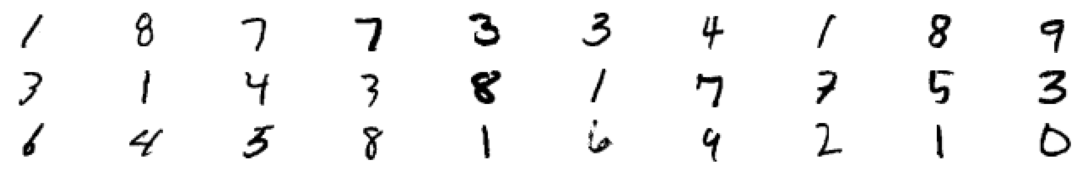

In [ ]:
# in order to get index number of images (0 to 9) to feed to the model
figure = plt.figure()
number_of_images = 30

for index in range(1, number_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
images_real = images[[30,1,28,11,22,23,21,3,2,10]]
labels_real = labels[[30,1,28,11,22,23,21,3,2,10]]

In [ ]:
labels_real

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
real_imgs = Variable(images_real.type(Tensor))\

encoded_imgs = encoder(real_imgs)

decoded_imgs = decoder(encoded_imgs)

In [ ]:
images_show = []

for i,j in zip( list(real_imgs.cpu().detach().numpy().squeeze()), list(decoded_imgs.cpu().detach().numpy().squeeze())):
    images_show.append(i)
    images_show.append(j)

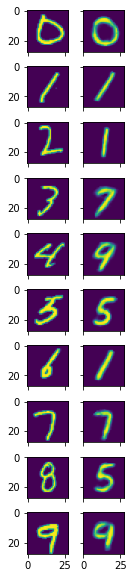

In [ ]:
fig = plt.figure(figsize=(10, 10))

grid = ImageGrid(fig, 111, nrows_ncols=(10, 2), axes_pad=0.2)

for ax, im in zip(grid, images_show):
    ax.imshow(im)
plt.show()

### *Plotting the Reconstruction loss and Discriminator loss over all the epochs*

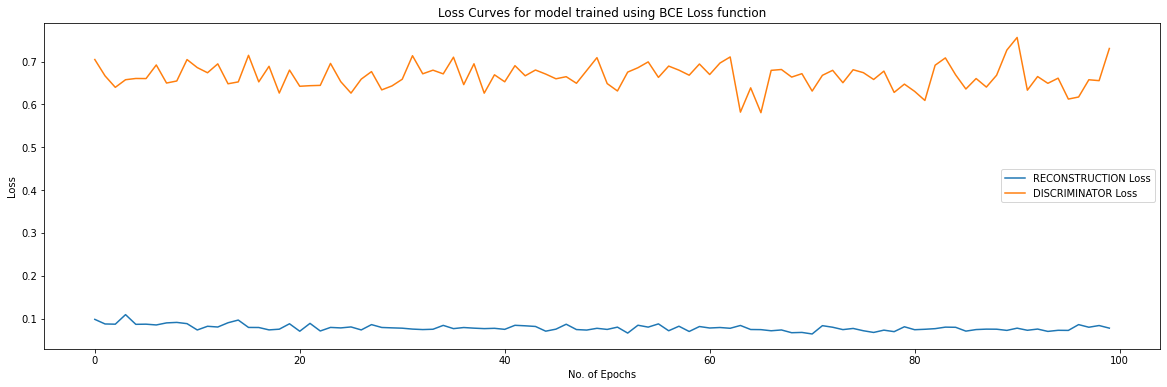

In [ ]:
x=[i for i in range(len(reconstruction_loss_bce_epochwise))]

plt.rcParams["figure.figsize"] = (20,6)
plt.plot(x, reconstruction_loss_bce_epochwise, label = "RECONSTRUCTION Loss")

plt.plot(x, discriminator_loss_bce_epochwise, label = "DISCRIMINATOR Loss")
plt.title("Loss Curves for model trained using BCE Loss function")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

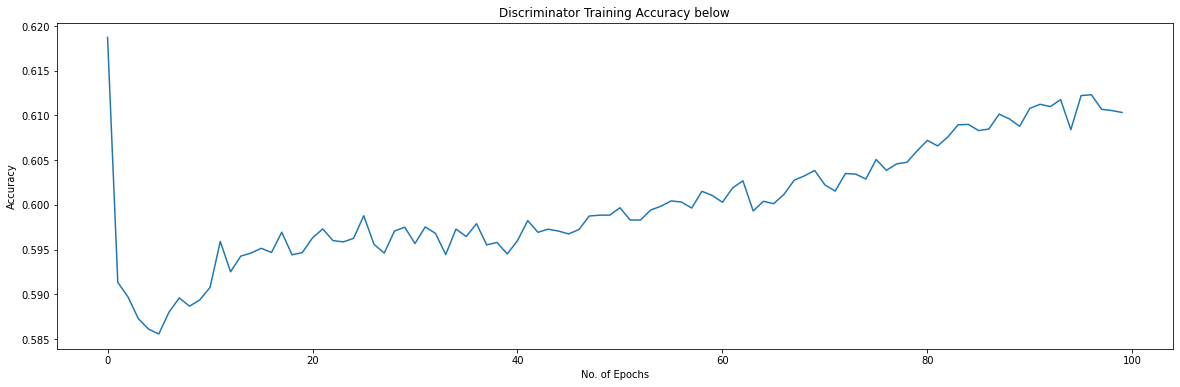

In [ ]:
plt.plot(x, discriminator_accuracy_bce_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY")
plt.title("Discriminator Training Accuracy below")

plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.show()

### 2. **SSIM Loss**

In [ ]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss_1.cuda()
    pixelwise_loss_ssim.cuda()
    adversarial_loss_3.cuda()
    pixelwise_loss.cuda()
    
optimize_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr_autoEncoder, betas=(b1, b2))

optimize_D = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(b1, b2))

In [ ]:
reconstruction_loss_ssim_stepwise = []

discriminator_Loss_ssim_stepwise = []

reconstruction_loss_ssim_epochwise = []

discriminator_Loss_ssim_epochwise = []

generator_loss_ssim_epochwise =[]

discriminator_accuracy_ssim_loss_setting_epochwise = []

for epoch in tqdm(range(1,n_epochs+1), desc="Epoch ", leave = True, position = 0):
  predictions_for_real_images_epoch = []
  predictions_for_fake_images_epoch = []
  
  for i, (imgs, _) in enumerate(training_dataloader):
      ONES = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      ZEROS = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configuring input
      real_imgs = Variable(imgs.type(Tensor))

      #  Train Generator
      
      optimize_G.zero_grad()
      encoded_imgs = encoder(real_imgs)
      decoded_imgs = decoder(encoded_imgs)

      # Generator Loss
      pixel_loss = pixelwise_loss_ssim(torch.stack([decoded_imgs,decoded_imgs,decoded_imgs], axis =1).squeeze(), torch.stack([real_imgs,real_imgs,real_imgs], axis =1).squeeze())
      adv_loss = adversarial_loss_1(discriminator(encoded_imgs), ONES)
      g_loss = 0.001 * adv_loss + 0.999 * pixel_loss
    
      reconstruction_loss_ssim_stepwise.append(pixel_loss.item())
      g_loss.backward()
      optimize_G.step()

      
      #  Train Discriminator
     
      optimize_D.zero_grad()
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

      # Discriminator Loss
      predictions_for_real_images = discriminator(z)
      predictions_for_fake_images = discriminator(encoded_imgs.detach())
      
      for r,f in zip(predictions_for_real_images.detach().cpu().numpy(),predictions_for_fake_images.detach().cpu().numpy()):
            if (r[0]>=0.5):
                predictions_for_real_images_epoch.append(1)
            else:
                predictions_for_real_images_epoch.append(0)
            if (f[0]>=0.5):
                predictions_for_fake_images_epoch.append(1)
            else:
                predictions_for_fake_images_epoch.append(0)

      real_loss = adversarial_loss_1(predictions_for_real_images, ONES)

      fake_loss = adversarial_loss_1(predictions_for_fake_images, ZEROS)
      
      d_loss = 0.5 * (real_loss + fake_loss)
      
      discriminator_loss_bce_stepwise.append(d_loss.item())
      
      d_loss.backward()
      
      optimize_D.step()

      if (epoch%5==0) & ((i+1)==len(training_dataloader)):
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i+1, len(training_dataloader), d_loss.item(), g_loss.item()))
      else:
        pass
    
     
      # after one epoch completes, then
      if (i+1)==len(training_dataloader):
        reconstruction_loss_ssim_epochwise.append(pixel_loss.item())
        discriminator_Loss_ssim_epochwise.append(d_loss.item())
        generator_loss_ssim_epochwise.append(g_loss.item())
        
        real_accuracy = accuracy_score([1]*len(predictions_for_real_images_epoch),predictions_for_real_images_epoch)
        fake_accuracy = accuracy_score([0]*len(predictions_for_fake_images_epoch),predictions_for_fake_images_epoch)
        d_acc = 0.5 * (real_accuracy+ fake_accuracy )
        discriminator_accuracy_ssim_loss_setting_epochwise.append(d_acc)
      
      else:
        pass      

Epoch :   5%|▌         | 5/100 [01:49<34:19, 21.68s/it]

[Epoch 5/100] [Batch 938/938] [D loss: 0.533345] [G loss: 0.527744]


Epoch :  10%|█         | 10/100 [03:39<32:43, 21.81s/it]

[Epoch 10/100] [Batch 938/938] [D loss: 0.570996] [G loss: 0.518165]


Epoch :  15%|█▌        | 15/100 [05:27<30:43, 21.69s/it]

[Epoch 15/100] [Batch 938/938] [D loss: 0.543016] [G loss: 0.442678]


Epoch :  20%|██        | 20/100 [07:17<29:09, 21.86s/it]

[Epoch 20/100] [Batch 938/938] [D loss: 0.626308] [G loss: 0.464011]


Epoch :  25%|██▌       | 25/100 [09:06<27:07, 21.71s/it]

[Epoch 25/100] [Batch 938/938] [D loss: 0.675832] [G loss: 0.417394]


Epoch :  30%|███       | 30/100 [10:55<25:28, 21.83s/it]

[Epoch 30/100] [Batch 938/938] [D loss: 0.646785] [G loss: 0.497853]


Epoch :  35%|███▌      | 35/100 [12:43<23:30, 21.70s/it]

[Epoch 35/100] [Batch 938/938] [D loss: 0.622482] [G loss: 0.422252]


Epoch :  40%|████      | 40/100 [14:32<21:51, 21.85s/it]

[Epoch 40/100] [Batch 938/938] [D loss: 0.628176] [G loss: 0.442363]


Epoch :  45%|████▌     | 45/100 [16:20<19:54, 21.73s/it]

[Epoch 45/100] [Batch 938/938] [D loss: 0.670970] [G loss: 0.464397]


Epoch :  50%|█████     | 50/100 [18:09<18:03, 21.68s/it]

[Epoch 50/100] [Batch 938/938] [D loss: 0.682146] [G loss: 0.470027]


Epoch :  55%|█████▌    | 55/100 [19:57<16:14, 21.66s/it]

[Epoch 55/100] [Batch 938/938] [D loss: 0.617704] [G loss: 0.471491]


Epoch :  60%|██████    | 60/100 [21:46<14:33, 21.84s/it]

[Epoch 60/100] [Batch 938/938] [D loss: 0.658413] [G loss: 0.373890]


Epoch :  65%|██████▌   | 65/100 [23:37<13:04, 22.42s/it]

[Epoch 65/100] [Batch 938/938] [D loss: 0.669224] [G loss: 0.509045]


Epoch :  70%|███████   | 70/100 [25:26<10:54, 21.81s/it]

[Epoch 70/100] [Batch 938/938] [D loss: 0.734765] [G loss: 0.484001]


Epoch :  75%|███████▌  | 75/100 [27:13<08:59, 21.57s/it]

[Epoch 75/100] [Batch 938/938] [D loss: 0.671351] [G loss: 0.409617]


Epoch :  80%|████████  | 80/100 [29:01<07:11, 21.57s/it]

[Epoch 80/100] [Batch 938/938] [D loss: 0.651393] [G loss: 0.394061]


Epoch :  85%|████████▌ | 85/100 [30:51<05:27, 21.84s/it]

[Epoch 85/100] [Batch 938/938] [D loss: 0.570469] [G loss: 0.339707]


Epoch :  90%|█████████ | 90/100 [32:40<03:37, 21.70s/it]

[Epoch 90/100] [Batch 938/938] [D loss: 0.675543] [G loss: 0.441058]


Epoch :  95%|█████████▌| 95/100 [34:28<01:48, 21.76s/it]

[Epoch 95/100] [Batch 938/938] [D loss: 0.612018] [G loss: 0.397607]


Epoch : 100%|██████████| 100/100 [36:17<00:00, 21.78s/it]

[Epoch 100/100] [Batch 938/938] [D loss: 0.540807] [G loss: 0.347738]


### *Displaying Real Images and Generated Images*

In [ ]:
dataiter = iter(testing_dataloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number are  (0 - 9) 

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


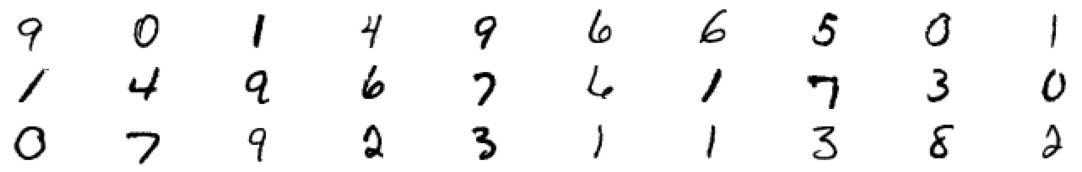

In [ ]:
# in order to get index number of images (0 to 9) to feed to the model
figure = plt.figure()
number_of_images = 30
for index in range(1, number_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
images_real = images[[9,3,30,19,4,8,7,22,29,5]]
labels_real = labels[[9,3,30,19,4,8,7,22,29,5]]
labels_real

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
real_imgs = Variable(images_real.type(Tensor))
encoded_imgs = encoder(real_imgs)
decoded_imgs = decoder(encoded_imgs)

In [ ]:
images_show = []
for i,j in zip( list(real_imgs.cpu().detach().numpy().squeeze()), list(decoded_imgs.cpu().detach().numpy().squeeze())):
    images_show.append(i)
    images_show.append(j)

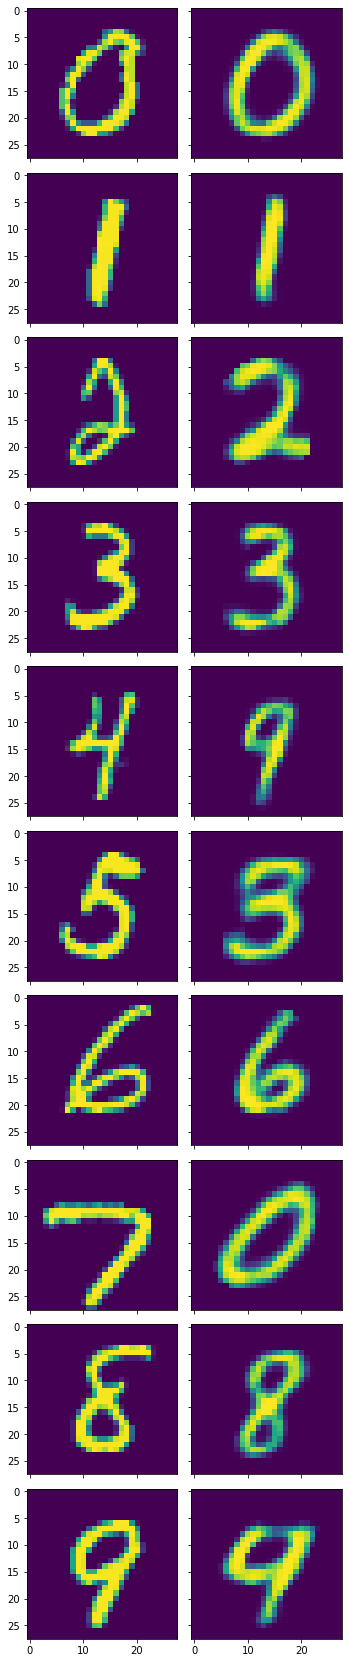

In [ ]:
fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 2), axes_pad=0.2)
for ax, im in zip(grid, images_show):
    ax.imshow(im)
plt.show()

### *Plotting the Reconstruction loss and Discriminator loss over all the epochs*

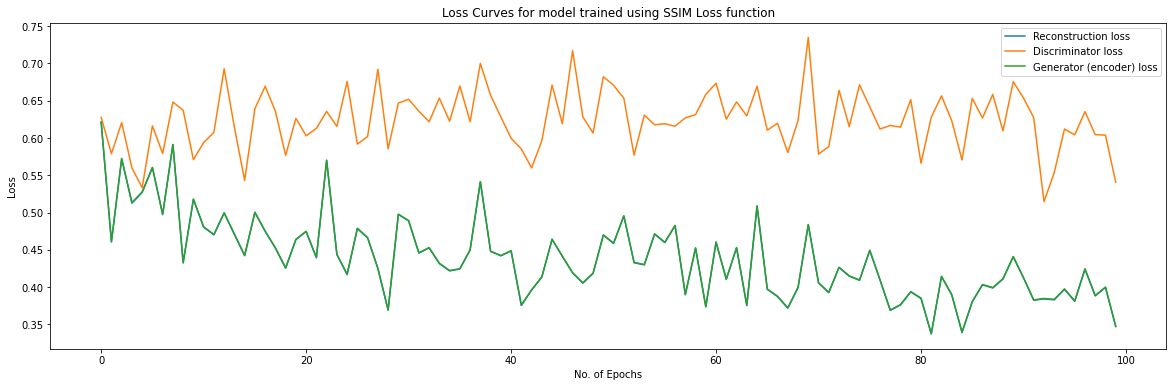

In [ ]:
x=[i for i in range(len(reconstruction_loss_ssim_epochwise))]
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(x, reconstruction_loss_ssim_epochwise, label = "Reconstruction loss")

plt.plot(x, discriminator_Loss_ssim_epochwise, label = "Discriminator loss")

plt.plot(x, generator_loss_ssim_epochwise, label = "Generator (encoder) loss")

plt.title("Loss Curves for model trained using SSIM Loss function")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

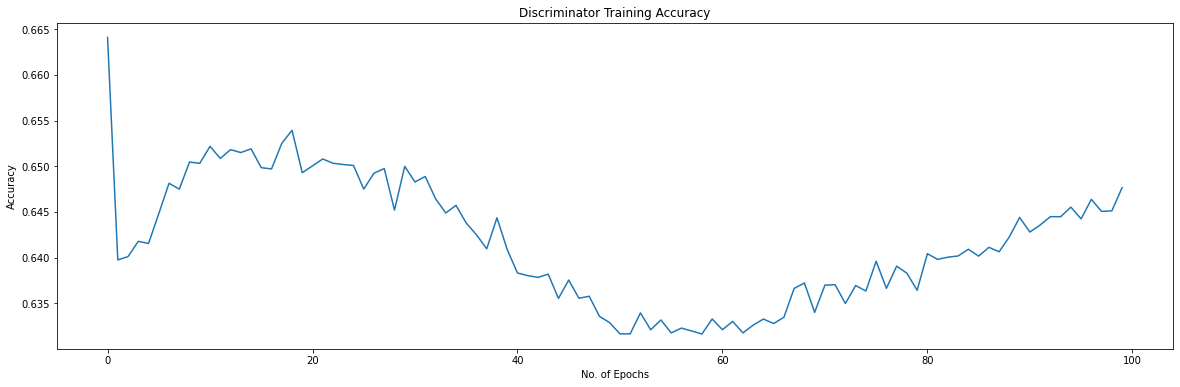

In [ ]:
plt.plot(x, discriminator_accuracy_ssim_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY")
plt.title("Discriminator Training Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")

### 3. **MSE Loss**

In [ ]:
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss_1.cuda()
    pixelwise_loss_ssim.cuda()
    adversarial_loss_3.cuda()
    pixelwise_loss.cuda()
    
optimize_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr_autoEncoder, betas=(b1, b2))

optimize_D = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(b1, b2))

In [ ]:
reconstruction_loss_mse_stepwise = []

discriminator_Loss_mse_stepwise = []

reconstruction_loss_mse_epochwise = []

discriminator_Loss_mse_epochwise = []

generator_loss_mse_epochwise =[]

discriminator_accuracy_mse_loss_setting_epochwise = []

for epoch in tqdm(range(1,n_epochs+1), desc="Epoch ", leave = True, position = 0):
  predictions_for_real_images_epoch = []
  predictions_for_fake_images_epoch = []
  
  for i, (imgs, _) in enumerate(training_dataloader):
      ONES = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
      ZEROS = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(Tensor))

      
      #  Train Generator
     
      optimize_G.zero_grad()
      encoded_imgs = encoder(real_imgs)
      decoded_imgs = decoder(encoded_imgs)

      # Generator Loss
      pixel_loss = pixelwise_loss(decoded_imgs, real_imgs)
      adv_loss = adversarial_loss_3(discriminator(encoded_imgs), ONES)
      g_loss = 0.001 * adv_loss + 0.999 * pixel_loss
      reconstruction_loss_mse_stepwise.append(pixel_loss.item())
      g_loss.backward()
      optimize_G.step()

     
      #  Train Discriminator
     
      optimize_D.zero_grad()
      z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

      # Discriminator Loss
      predictions_for_real_images = discriminator(z)
      predictions_for_fake_images = discriminator(encoded_imgs.detach())
      
      for r,f in zip(predictions_for_real_images.detach().cpu().numpy(),predictions_for_fake_images.detach().cpu().numpy()):
            if (r[0]>=0.5):
                predictions_for_real_images_epoch.append(1)
            else:
                predictions_for_real_images_epoch.append(0)
            if (f[0]>=0.5):
                predictions_for_fake_images_epoch.append(1)
            else:
                predictions_for_fake_images_epoch.append(0)

      real_loss = adversarial_loss_3(predictions_for_real_images, ONES)

      fake_loss = adversarial_loss_3(predictions_for_fake_images, ZEROS)

      d_loss = 0.5 * (real_loss + fake_loss)

      discriminator_Loss_mse_stepwise.append(d_loss.item())
      d_loss.backward()
      optimize_D.step()

      if (epoch%5==0) & ((i+1)==len(training_dataloader)):
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i+1, len(training_dataloader), d_loss.item(), g_loss.item()))
      else:
        pass
    
      
      # if one epoch completes, then
      if (i+1)==len(training_dataloader):
        reconstruction_loss_mse_epochwise.append(pixel_loss.item())
        discriminator_Loss_mse_epochwise.append(d_loss.item())
        generator_loss_mse_epochwise.append(g_loss.item())
        
        real_accuracy = accuracy_score([1]*len(predictions_for_real_images_epoch),predictions_for_real_images_epoch)
        
        fake_accuracy = accuracy_score([0]*len(predictions_for_fake_images_epoch),predictions_for_fake_images_epoch)
        
        d_acc = 0.5 * (real_accuracy+ fake_accuracy )
        discriminator_accuracy_mse_loss_setting_epochwise.append(d_acc)
      
      else:
        pass      

Epoch :   5%|▌         | 5/100 [01:34<30:06, 19.01s/it]

[Epoch 5/100] [Batch 938/938] [D loss: 0.241410] [G loss: 0.083063]


Epoch :  10%|█         | 10/100 [03:08<28:02, 18.69s/it]

[Epoch 10/100] [Batch 938/938] [D loss: 0.215058] [G loss: 0.092687]


Epoch :  15%|█▌        | 15/100 [04:43<26:54, 19.00s/it]

[Epoch 15/100] [Batch 938/938] [D loss: 0.217813] [G loss: 0.079323]


Epoch :  20%|██        | 20/100 [06:16<24:55, 18.69s/it]

[Epoch 20/100] [Batch 938/938] [D loss: 0.242726] [G loss: 0.079340]


Epoch :  25%|██▌       | 25/100 [07:49<23:17, 18.63s/it]

[Epoch 25/100] [Batch 938/938] [D loss: 0.217105] [G loss: 0.081175]


Epoch :  30%|███       | 30/100 [09:23<21:53, 18.77s/it]

[Epoch 30/100] [Batch 938/938] [D loss: 0.252005] [G loss: 0.098082]


Epoch :  35%|███▌      | 35/100 [10:57<20:24, 18.84s/it]

[Epoch 35/100] [Batch 938/938] [D loss: 0.227188] [G loss: 0.079660]


Epoch :  40%|████      | 40/100 [12:31<18:44, 18.75s/it]

[Epoch 40/100] [Batch 938/938] [D loss: 0.241130] [G loss: 0.082528]


Epoch :  45%|████▌     | 45/100 [14:04<17:12, 18.77s/it]

[Epoch 45/100] [Batch 938/938] [D loss: 0.235700] [G loss: 0.078508]


Epoch :  50%|█████     | 50/100 [15:38<15:40, 18.81s/it]

[Epoch 50/100] [Batch 938/938] [D loss: 0.255261] [G loss: 0.071962]


Epoch :  55%|█████▌    | 55/100 [17:12<14:03, 18.73s/it]

[Epoch 55/100] [Batch 938/938] [D loss: 0.253142] [G loss: 0.076933]


Epoch :  60%|██████    | 60/100 [18:46<12:28, 18.72s/it]

[Epoch 60/100] [Batch 938/938] [D loss: 0.228130] [G loss: 0.078807]


Epoch :  65%|██████▌   | 65/100 [20:20<10:56, 18.76s/it]

[Epoch 65/100] [Batch 938/938] [D loss: 0.226141] [G loss: 0.081794]


Epoch :  70%|███████   | 70/100 [21:53<09:22, 18.74s/it]

[Epoch 70/100] [Batch 938/938] [D loss: 0.246149] [G loss: 0.070862]


Epoch :  75%|███████▌  | 75/100 [23:27<07:47, 18.70s/it]

[Epoch 75/100] [Batch 938/938] [D loss: 0.251550] [G loss: 0.071357]


Epoch :  80%|████████  | 80/100 [25:01<06:15, 18.78s/it]

[Epoch 80/100] [Batch 938/938] [D loss: 0.208629] [G loss: 0.072270]


Epoch :  85%|████████▌ | 85/100 [26:35<04:42, 18.85s/it]

[Epoch 85/100] [Batch 938/938] [D loss: 0.264474] [G loss: 0.077691]


Epoch :  90%|█████████ | 90/100 [28:09<03:07, 18.78s/it]

[Epoch 90/100] [Batch 938/938] [D loss: 0.218575] [G loss: 0.075547]


Epoch :  95%|█████████▌| 95/100 [29:42<01:33, 18.76s/it]

[Epoch 95/100] [Batch 938/938] [D loss: 0.227273] [G loss: 0.061168]


Epoch : 100%|██████████| 100/100 [31:17<00:00, 18.77s/it]

[Epoch 100/100] [Batch 938/938] [D loss: 0.219602] [G loss: 0.075891]


### *Displaying Real Images and Generated Images*

In [ ]:
dataiter = iter(testing_dataloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


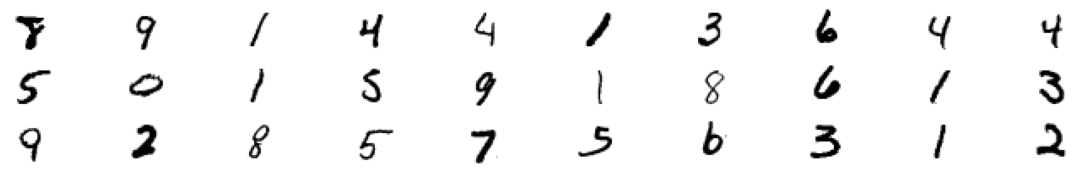

In [ ]:
# in order to get index number of images (0 to 9) to feed to the model
figure = plt.figure()
number_of_images = 30
for index in range(1, number_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
images_real = images[[12,3,30,7,4,24,8,25,17,15]]
labels_real = labels[[12,3,30,7,4,24,8,25,17,15]]
labels_real

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
real_imgs = Variable(images_real.type(Tensor))
encoded_imgs = encoder(real_imgs)
decoded_imgs = decoder(encoded_imgs)

In [ ]:
images_show = []
for i,j in zip( list(real_imgs.cpu().detach().numpy().squeeze()), list(decoded_imgs.cpu().detach().numpy().squeeze())):
    images_show.append(i)
    images_show.append(j)

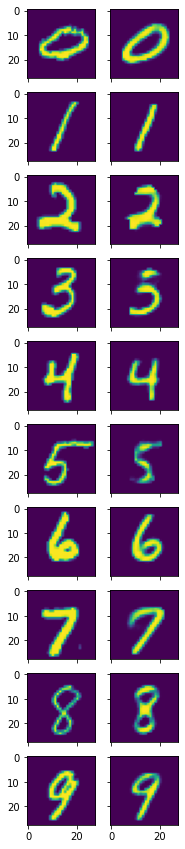

In [ ]:
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 2), axes_pad=0.2)
for ax, im in zip(grid, images_show):
    ax.imshow(im)
plt.show()

### *Plotting the Reconstruction loss and Discriminator loss over all the epochs*

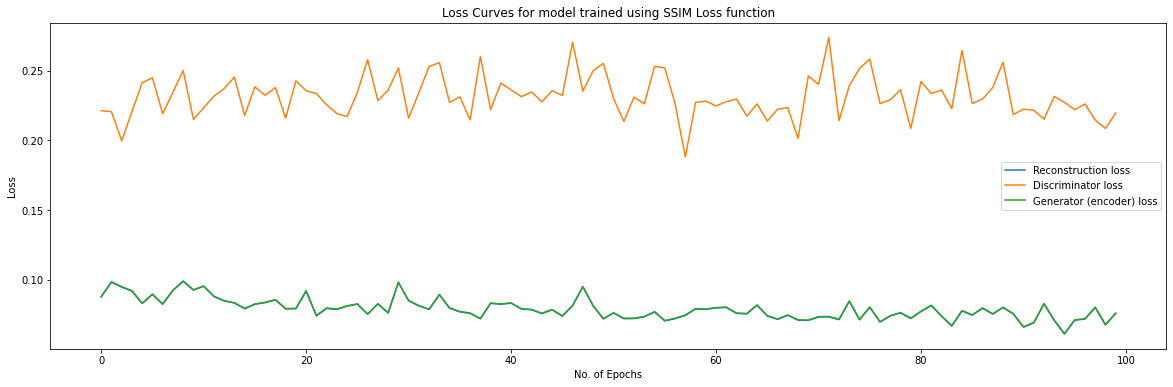

In [ ]:
x=[i for i in range(len(reconstruction_loss_mse_epochwise))]
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(x, reconstruction_loss_mse_epochwise, label = "Reconstruction loss")

plt.plot(x, discriminator_Loss_mse_epochwise, label = "Discriminator loss")

plt.plot(x, generator_loss_mse_epochwise, label = "Generator (encoder) loss")

plt.title("Loss Curves for model trained using SSIM Loss function")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Text(0, 0.5, 'Accuracy')

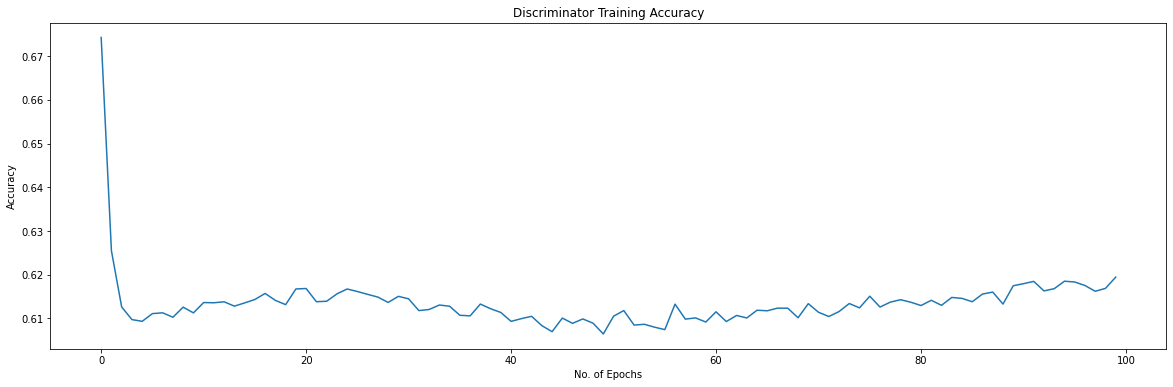

In [ ]:
plt.plot(x, discriminator_accuracy_mse_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY")
plt.title("Discriminator Training Accuracy")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")

***Some of the plots are present above ,  in between the code cells as well***

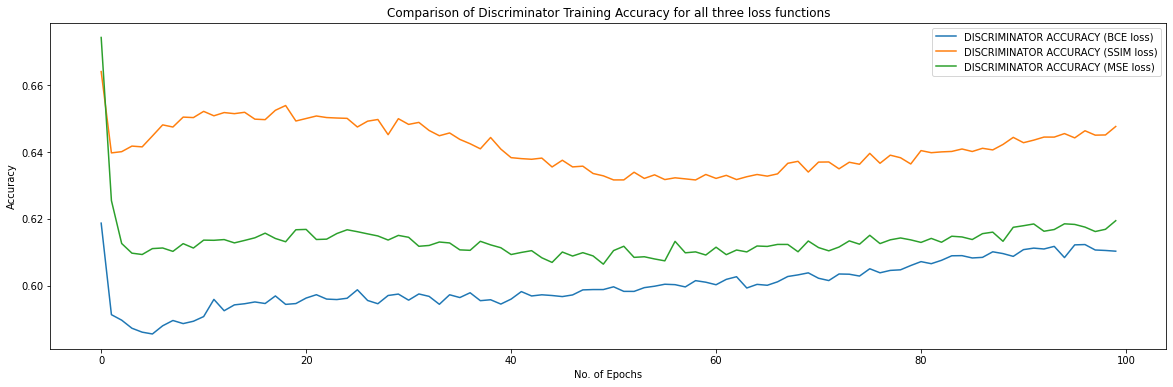

In [ ]:
plt.plot(x, discriminator_accuracy_bce_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY (BCE loss)")

plt.plot(x, discriminator_accuracy_ssim_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY (SSIM loss)")

plt.plot(x, discriminator_accuracy_mse_loss_setting_epochwise, label = "DISCRIMINATOR ACCURACY (MSE loss)")
plt.title("Comparison of Discriminator Training Accuracy for all three loss functions")
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

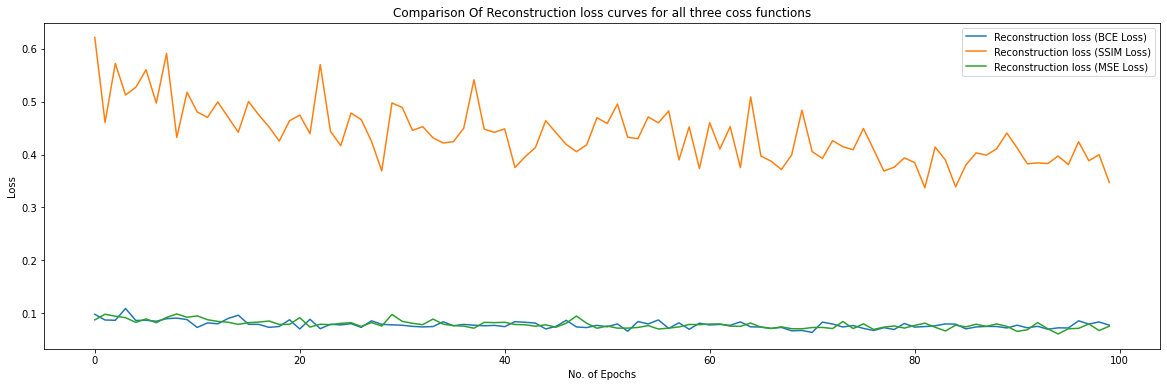

In [ ]:
x=[i for i in range(len(reconstruction_loss_bce_epochwise))]
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(x, reconstruction_loss_bce_epochwise, label = "Reconstruction loss (BCE Loss)")

plt.plot(x, reconstruction_loss_ssim_epochwise, label = "Reconstruction loss (SSIM Loss)")

plt.plot(x, reconstruction_loss_mse_epochwise, label = "Reconstruction loss (MSE Loss)")

plt.title("Comparison Of Reconstruction loss curves for all three coss functions")

plt.xlabel("No. of Epochs")

plt.ylabel("Loss")
plt.legend()
plt.show()

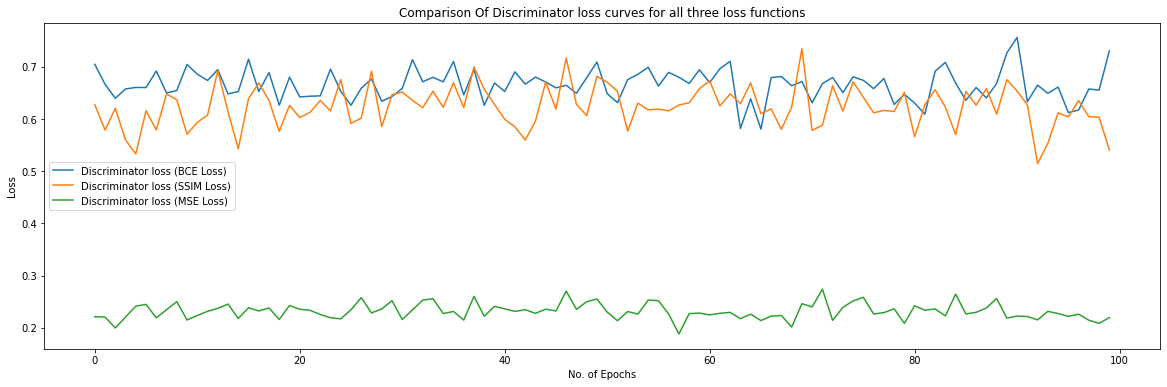

In [ ]:
x=[i for i in range(len(reconstruction_loss_bce_epochwise))]
plt.rcParams["figure.figsize"] = (20,6)

plt.plot(x, discriminator_loss_bce_epochwise, label = "Discriminator loss (BCE Loss)")

plt.plot(x, discriminator_Loss_ssim_epochwise, label = "Discriminator loss (SSIM Loss)")

plt.plot(x, discriminator_Loss_mse_epochwise, label = "Discriminator loss (MSE Loss)")
plt.title("Comparison Of Discriminator loss curves for all three loss functions")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

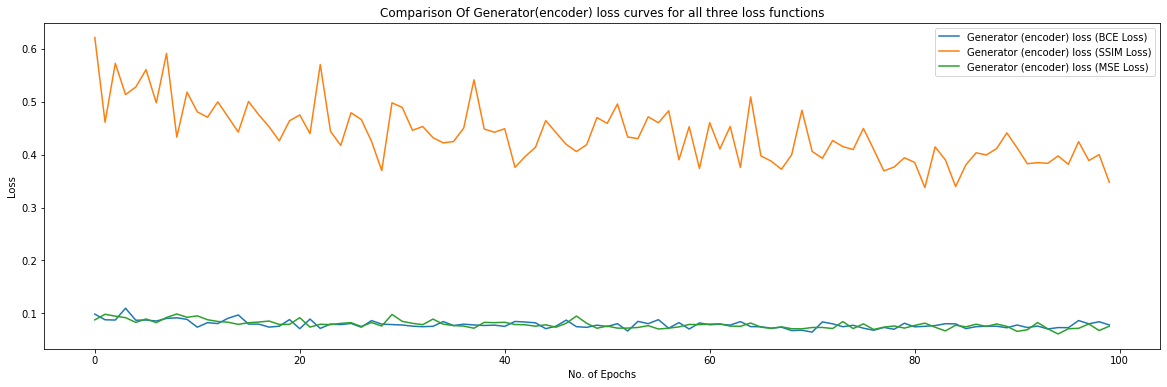

In [ ]:
x=[i for i in range(len(reconstruction_loss_bce_epochwise))]
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(x,  generator_loss_bce_epochwise, label = "Generator (encoder) loss (BCE Loss)")

plt.plot(x,  generator_loss_ssim_epochwise, label = "Generator (encoder) loss (SSIM Loss)")

plt.plot(x, generator_loss_mse_epochwise, label = "Generator (encoder) loss (MSE Loss)")

plt.title("Comparison Of Generator(encoder) loss curves for all three loss functions")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()